In [1]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 2 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

no_preview = True # Toggle to False to use the preview widget
                  # instead of rendering for scene visualization

from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera,\
                      PathSolver, ITURadioMaterial, SceneObject

import matplotlib.pyplot as plt

import mitsuba as mi

import numpy as np

import sionnautils
from scipy.spatial.transform import Rotation as R

from UE2_config import UE2

import mitsuba as mi
import drjit as dr
from sionna.rt import AntennaPattern, PlanarArray, register_antenna_pattern
from sionnautils.custom_scene import list_scenes, get_scene



In [2]:
def is_inside_building_mitsuba(scene, point, direction=np.array([0, 0, 1]), max_hits=50):
    """
    Casts a ray and counts intersections to determine if point is inside a mesh.
    """
    ray_origin = mi.Point3f(point)
    ray_dir = mi.Vector3f(direction)
    ray = mi.Ray3f(o=ray_origin, d=ray_dir)

    scene_mi = scene._scene  # Internal Mitsuba scene from Sionna

    count = 0
    for _ in range(max_hits):
        si = scene_mi.ray_intersect(ray, active=dr.ones(mi.Bool, 1)[0])
        if not si.is_valid():
            break
        count += 1
        ray.o = si.p + 1e-4 * ray.d  # Offset origin to avoid repeated self-hit

    return (count % 2 == 1)

def ue_inside_building(scene, point, direction=np.array([0, 0, 1]), max_hits=50):
    
    check_rx1 = is_inside_building_mitsuba(scene, point + np.array([-0.04,0.09,0]))
    check_rx2 = is_inside_building_mitsuba(scene, point + np.array([0.04,-0.09,0]))
    check_rx3 = is_inside_building_mitsuba(scene, point + np.array([0.04,0.09,0]))
    check_rx4 = is_inside_building_mitsuba(scene, point + np.array([-0.04,-0.09,0]))
    
    return check_rx1 and check_rx2 and check_rx3 and check_rx4

In [3]:
from matplotlib.path import Path

def is_point_in_region(region_vertices_3d, point_3d):

    point_xy = point_3d[:2]
    polygon_xy = region_vertices_3d[:, :2]
    path = Path(polygon_xy)
    return path.contains_point(point_xy)


In [4]:
from sionnautils.custom_scene import list_scenes, get_scene
scenes = list_scenes()
print(scenes)

scene_path, map_data = get_scene('nyu_tandon')
for k, v in map_data.items():
    print(f'{k}: {v}')

scene = load_scene(scene_path,merge_shapes=True)

floor = scene.get('ground')
# print(f'Floor material: {floor.radio_material.name}')
floor.radio_material = ITURadioMaterial("itu_concrete",
                                "concrete",
                                thickness=0.01,
                                color=(0.5, 0.5, 0.5))

scene.remove("itu_wet_ground")

for name, obj in scene.objects.items():
    print(f'{name:<15}{obj.radio_material.name}')
# scene.render(camera=my_cam, num_samples=512)

scene.radio_materials

['nyu_tandon']
bbox_lat: [40.69012764197041, 40.699120858029595]
bbox_long: [-73.99156687083165, -73.97970552916836]
address: 5 MetroTech Center, Brooklyn, NY 11201
descr: NYU Tandon campus


2025-09-19 23:09:04 WARN wrk6 [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).

no-name-1      itu_marble
ground         itu_concrete


{'itu_marble': ITURadioMaterial type=marble
                  eta_r=7.074
                  sigma=0.018
                  thickness=0.100
                  scattering_coefficient=0.000
                  xpd_coefficient=0.000,
 'itu_concrete': ITURadioMaterial type=concrete
                  eta_r=5.240
                  sigma=0.123
                  thickness=0.010
                  scattering_coefficient=0.000
                  xpd_coefficient=0.000}

In [5]:
import gym
import numpy as np

# 42, 40, 226, 420, 812


# rand_seed = 812

# route 1_2
# rand_seed = 20250901

# route 1_3
# rand_seed = 812

# route 1_5
# rand_seed = 20250908


###########################################################
# route 1_6
# rand_seed = 20250912

#route 1_7
# rand_seed = 20250913

# 1_8
# rand_seed = 20250914

# 1_9
# rand_seed = 20250915

# 1_10
# rand_seed = 20250917

# 1_11
# rand_seed = 20250919

# 1_12
# rand_seed = 20250922

# 1_13
# rand_seed = 20250923

# 1_14
# rand_seed = 20250931

# 1_15
# rand_seed = 20250932


###########################################################
# route 1_21 to 40  V_max = 2mps
# rand_seed = 40

# route 1_41 to 60 V_max = 5mps
# rand_seed = 48

# route 1_61 to 80 V_max = 10mps
rand_seed = 80

file_route = "region_1_" + str(rand_seed) +"_60s_10mps.json"

# Constants
v = 3  # initial speed

v_max = 10
v_min = 0.0
dv_min, dv_max = -5, 5  # change in speed per seconds
dphi_min, dphi_max = -np.pi/4, np.pi/4  # change in angle per step
dt = 0.05  # time step in seconds

# Action space: [Δv, Δθ]
action_space = gym.spaces.Box(low=np.array([dv_min *dt, dphi_min *dt]),
                              high=np.array([dv_max *dt, dphi_max *dt]),
                              dtype=np.float64)
action_space.seed(rand_seed)
np.random.seed(rand_seed)


In [6]:

# Initial state
##### s1
# x, y, phi = 0, -50, np.pi 
# x, y, phi = -50, 8, np.pi / 2
# x, y, phi = 50, 30, 0 

##### region 1_1
# x, y, phi = -340, 562, np.pi /2

#### region 1_2 ...
x, y, phi = np.random.uniform(-388, -308), np.random.uniform(370, 460), np.random.uniform(-np.pi, np.pi)


# Store trajectory
trajectory = [(x, y, phi, v)]

routes = []
xs = []
ys = []
vs = []
angles = []

time = 60
n_steps = time / dt

# # s1 region
# region = np.array([[-125,35,1], [50,35,1],[50,-100,1],[-125,-100,1]])
# tx_loc =[50,-115,10]
# tx_loc =[-50,45,10]

# s2 region 1
region = np.array([[-428,352,1], [-308,352,1],[-308,500,1],[-428,500,1]])
tx_loc =[-300,0,10]

step = 0
while step < n_steps:
    
    # if step % 100 == 0:
    #     print(step)
    
    # Sample action
    dv, dphi = action_space.sample()

    # Update speed and clip
    v = np.clip(v + dv, v_min, v_max)

    # Update heading
    phi += dphi

    # Update position
    temp_x = x + v * np.cos(phi) * dt
    temp_y = y+ v * np.sin(phi) * dt
    
    test_point = np.array([temp_x,temp_y,1]) 
    if ue_inside_building(scene, test_point) or (not is_point_in_region(region, test_point)):
        print(step)
        phi = phi + np.random.choice([-1, 1]) * np.pi / 6
        continue
    
    x = temp_x
    y = temp_y

    # # Store new state
    # if phi > np.pi:
    #     phi -= 2* np.pi
    # elif phi <= -np.pi:
    #     phi += 2* np.pi
    
    trajectory.append((x, y, phi, v))
    
    xs.append(x)
    ys.append(y)
    angles.append(phi)
    vs.append(v)
    
    
    
    routes.append([x,y,1])
    step += 1

# Print the trajectory
for i, (x, y, phi, v) in enumerate(trajectory):
    print(f"Step {i:2d}: x = {x:.3f}, y = {y:.3f}, phi = {phi:.3f}, v = {v:.3f}")


429
429
429
429
430
893
893
897
Step  0: x = -346.247, y = 432.947, phi = -1.446, v = 3.000
Step  1: x = -346.233, y = 432.791, phi = -1.484, v = 3.118
Step  2: x = -346.220, y = 432.648, phi = -1.476, v = 2.887
Step  3: x = -346.209, y = 432.501, phi = -1.498, v = 2.929
Step  4: x = -346.195, y = 432.352, phi = -1.476, v = 2.998
Step  5: x = -346.184, y = 432.197, phi = -1.504, v = 3.121
Step  6: x = -346.176, y = 432.032, phi = -1.519, v = 3.293
Step  7: x = -346.170, y = 431.865, phi = -1.535, v = 3.347
Step  8: x = -346.167, y = 431.694, phi = -1.551, v = 3.409
Step  9: x = -346.162, y = 431.523, phi = -1.545, v = 3.429
Step 10: x = -346.154, y = 431.348, phi = -1.525, v = 3.507
Step 11: x = -346.148, y = 431.182, phi = -1.537, v = 3.322
Step 12: x = -346.148, y = 431.021, phi = -1.570, v = 3.218
Step 13: x = -346.148, y = 430.868, phi = -1.571, v = 3.050
Step 14: x = -346.148, y = 430.710, phi = -1.569, v = 3.171
Step 15: x = -346.152, y = 430.550, phi = -1.595, v = 3.207
Step 16:

In [7]:
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Create transmitter
tx = Transmitter(name="tx",
                position=tx_loc,
                 display_radius=5)
scene.remove("tx")
scene.add(tx)

# scene.preview()


In [8]:
scene.rx_array = PlanarArray(num_rows=1,
                              num_cols=1,
                              vertical_spacing=0.5,
                              horizontal_spacing=0.5,
                              pattern="iso",
                              polarization="V")


for idx in range(step):
    # print(idx)
    rx = Receiver(name=f"rx-{idx}",
              position=np.array(routes[idx]),
              display_radius=1)
    scene.remove(f"rx-{idx}")
    scene.add(rx)
    
# for idx in range(len(region)):
#     # print(idx)
#     rx = Receiver(name=f"region-{idx}",
#               position=np.array(region[idx]),
#               display_radius=2)
#     scene.add(rx)

In [9]:
# # Create new camera with different configuration
# my_cam = Camera(position=[-320,430,500], look_at=[-320,430,0])
# scene.render(camera=my_cam, resolution=[50,50])
scene.preview()


Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [10]:
measure_index = range(int(n_steps))
measure_index

range(0, 1200)

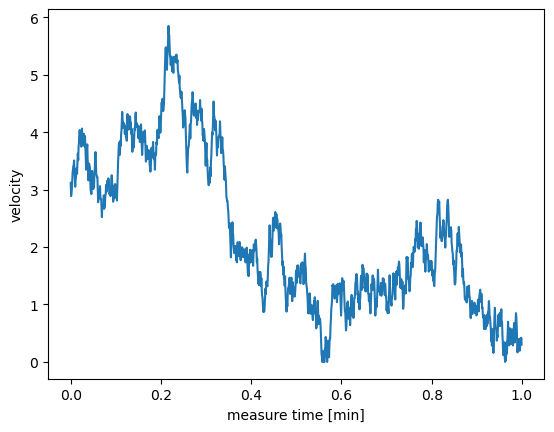

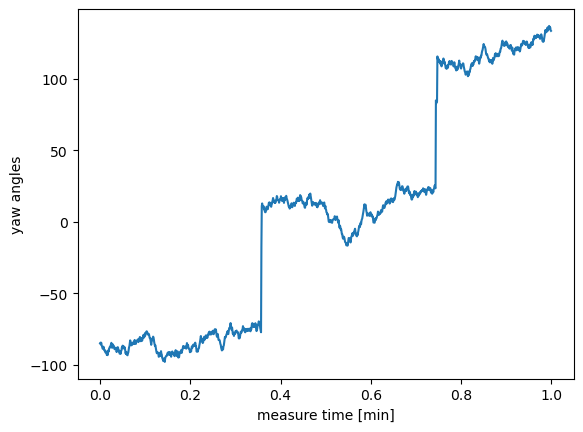

In [11]:


plt.figure()

plt.plot(np.array(measure_index) * dt / 60, np.array(vs), label=f"yaw angle")

# plt.legend(loc = "lower left")
plt.xlabel("measure time [min]")
plt.ylabel("velocity")
# plt.ylim(-75,-60)
plt.show()

plt.figure()

plt.plot(np.array(measure_index) * dt / 60, np.array(angles) / (2*np.pi) * 360, label=f"yaw angle")

# plt.legend(loc = "lower left")
plt.xlabel("measure time [min]")
plt.ylabel("yaw angles")
# plt.ylim(-75,-60)
plt.show()

In [ ]:
import json

with open(file_route, 'w') as f:
    json.dump(routes, f)
